In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.data.make_dataset import *
from src.data.modal_data import *

In [3]:
loc = 'nw2'
turbine = 'c02'
mode = 'whirling'

In [4]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
selected_data= pd.read_parquet(os.path.join(data_folder, 'processed','nw2',mode, turbine+'_' + mode + '_selected_data.parquet'))


In [5]:
from src.data.utils import get_input_data
from src.data.harmonics import *

data = get_input_data(data_folder, loc, turbine)
harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

In [6]:
selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

In [7]:
from src.data.make_dataset import create_input_data
mpe_ss_data = get_mpe_data(data['turbine_data'], 'SS', loc, turbine)

X = create_input_data(data_folder, loc, turbine)
X = X[selected_columns].loc[:datetime.datetime(2023, 6, 1, tzinfo=datetime.timezone.utc)]
y_train = selected_data['mean_frequency']

common_indices = X.dropna().index.intersection(y_train.dropna().index)
y_train = y_train.loc[common_indices]
X_train = pd.DataFrame(index = y_train.index)
for column in selected_columns:
    X_train[column] = X[column].loc[common_indices]

dropped mvbc columns:  {'mvbc_WandelaarMeasuringpile_Relative_humidity', 'mvbc_WandelaarBuoy_Sea_water_temperature'}


In [9]:
lower_freq = 0.6
upper_freq = 0.77
all_whirling = mpe_ss_data[(mpe_ss_data['mean_frequency'] < upper_freq) & (mpe_ss_data['mean_frequency'] > lower_freq)]

In [31]:
from hyperopt import hp, fmin, tpe, STATUS_OK
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

def objective(params):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    # List to store MSE for each fold
    mse_scores = []

    for train_index, test_index in kf.split(X_train):
        X_train_, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model = CatBoostRegressor(**params, random_seed=0, posterior_sampling=True, loss_function='RMSEWithUncertainty', silent=True)
        model.fit(X_train_, y_train_)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions[:,0])
        mse_scores.append(mse)

    # Average MSE over all folds
    avg_mse = np.mean(mse_scores)
    return {'loss': avg_mse, 'status': STATUS_OK}

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.6),
    'depth': hp.choice('depth', [2, 3, 4, 5]),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 5),
    'iterations': hp.choice('iterations', [1000, 1500, 2000, 3000])
}

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100
)

100%|██████████| 100/100 [52:38<00:00, 31.59s/trial, best loss: 7.291707092261688e-05] 


In [32]:
best

{'depth': 3,
 'iterations': 1,
 'l2_leaf_reg': 4.445887074940196,
 'learning_rate': 0.045346282902174725}

In [33]:
from catboost import CatBoostRegressor
regr_model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.045, l2_leaf_reg = 1.955, random_seed=0,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model = CatBoostRegressor(**best, random_seed=0,posterior_sampling=True, loss_function='RMSEWithUncertainty', silent=True)
regr_model.fit(X_train, y_train)

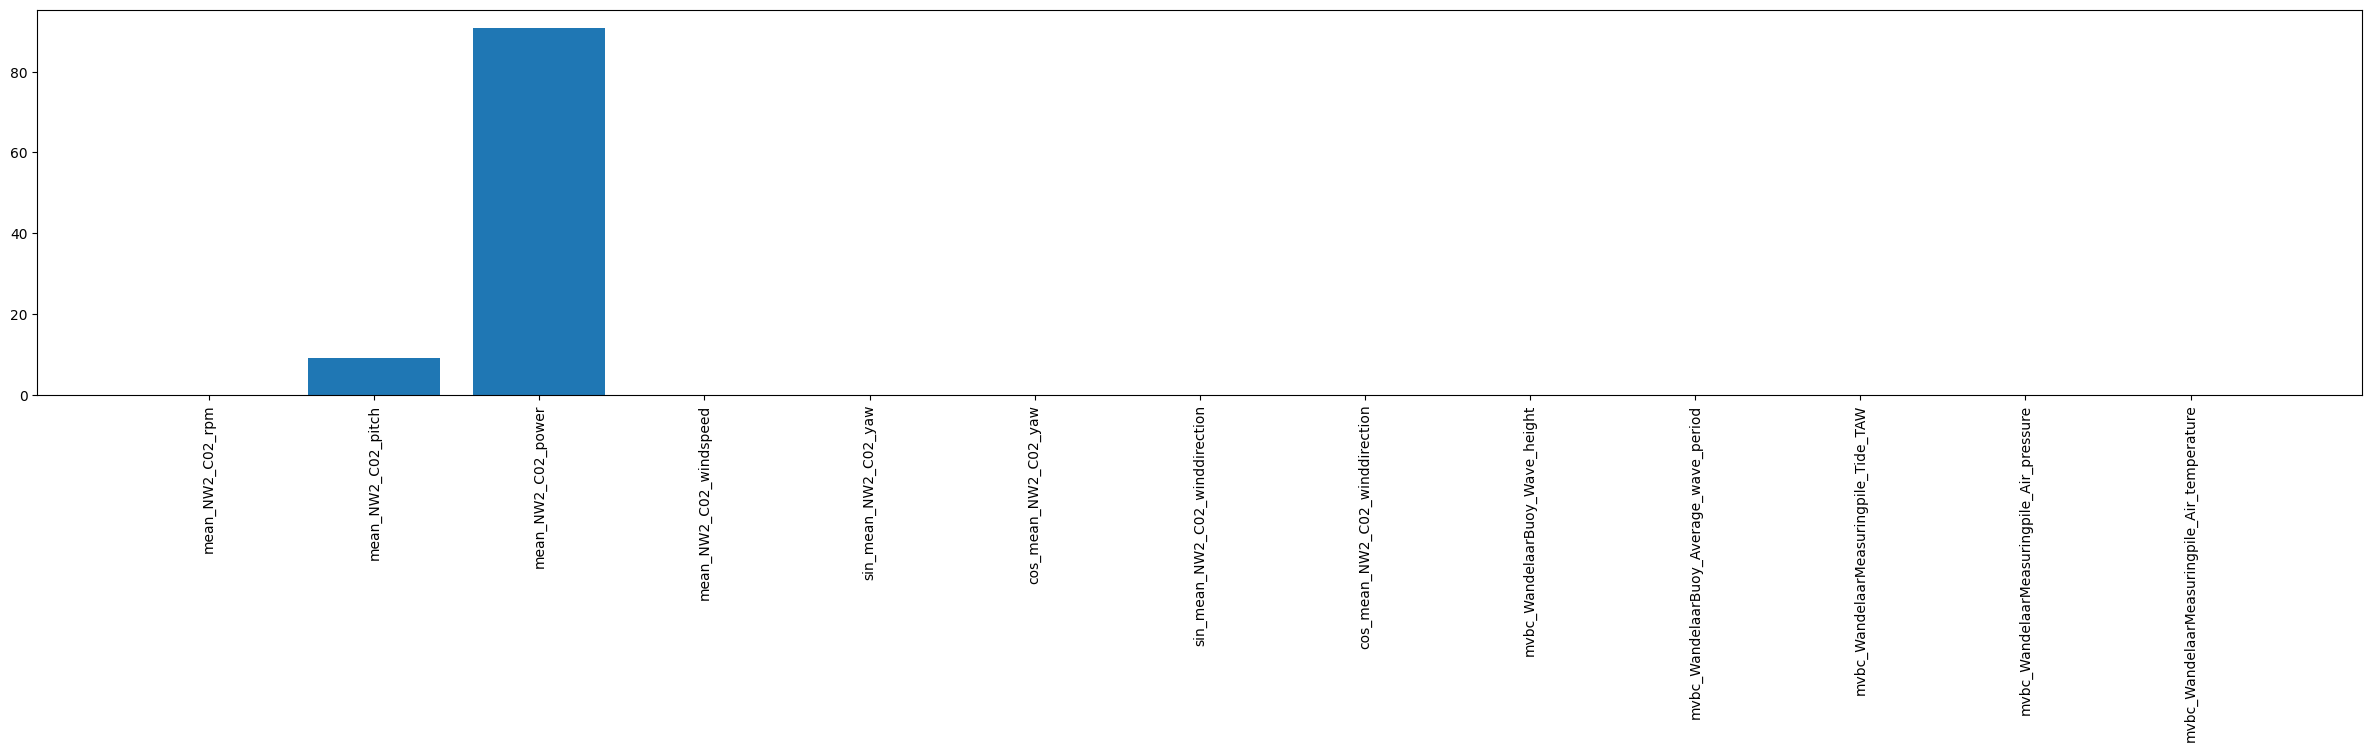

In [34]:
plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()
plt.close()

In [35]:
import pickle
models_folder = os.path.join(package_folder, 'models', loc)
model_path = os.path.join(models_folder, turbine, mode, '_'.join([loc, turbine, mode, 'catboost_model.pkl']))
with open(model_path, 'wb') as file:
    pickle.dump(regr_model, file)

In [36]:
# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=100, ntree_end=500) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()

uncertainty_lim = uncertainty_.loc[X_train.dropna().index].quantile(0.8)
prediction_lim = (y_train - predictions_df['prediction'].loc[X_train.dropna().index]).std()*1

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/algo/apply.cpp:43: Out of range treeEnd=500

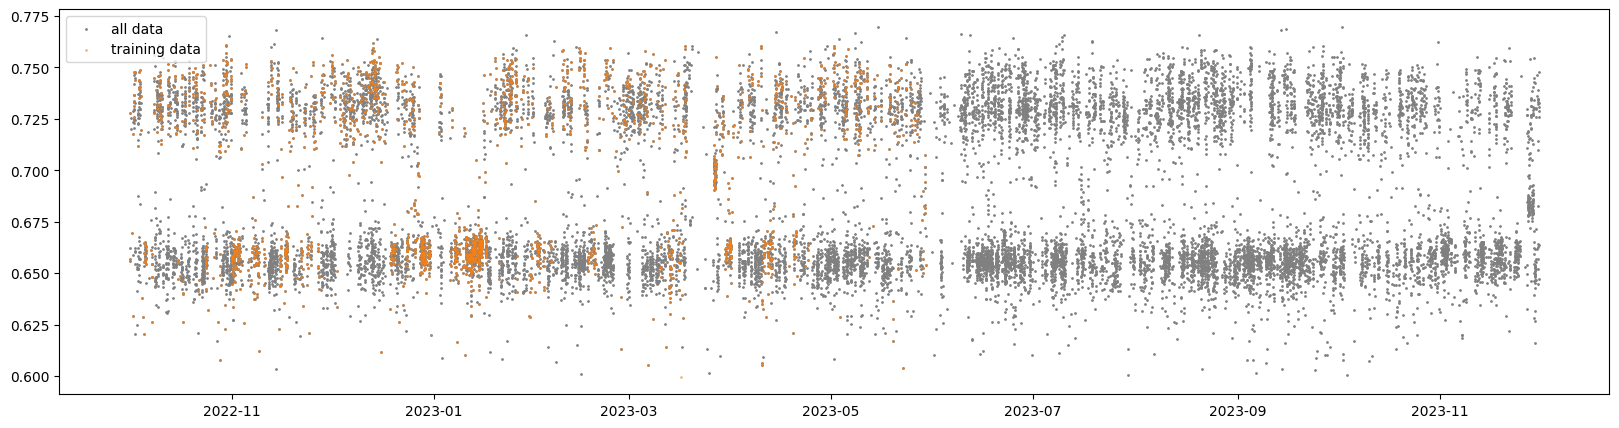

In [ ]:
plt.figure(figsize=(20,5))
plt.scatter(all_whirling.index, all_whirling['mean_frequency'], s=1, color='gray', label='all data')

plt.scatter(y_train.index, y_train, s=1, alpha=0.5, color='tab:orange', label='training data')
#plt.scatter(predictions_df.index, predictions_df['prediction'], s=1, alpha=0.5)
plt.legend(loc='upper left')
plt.show()
plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_19604\2865007364.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_19604\2865007364.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


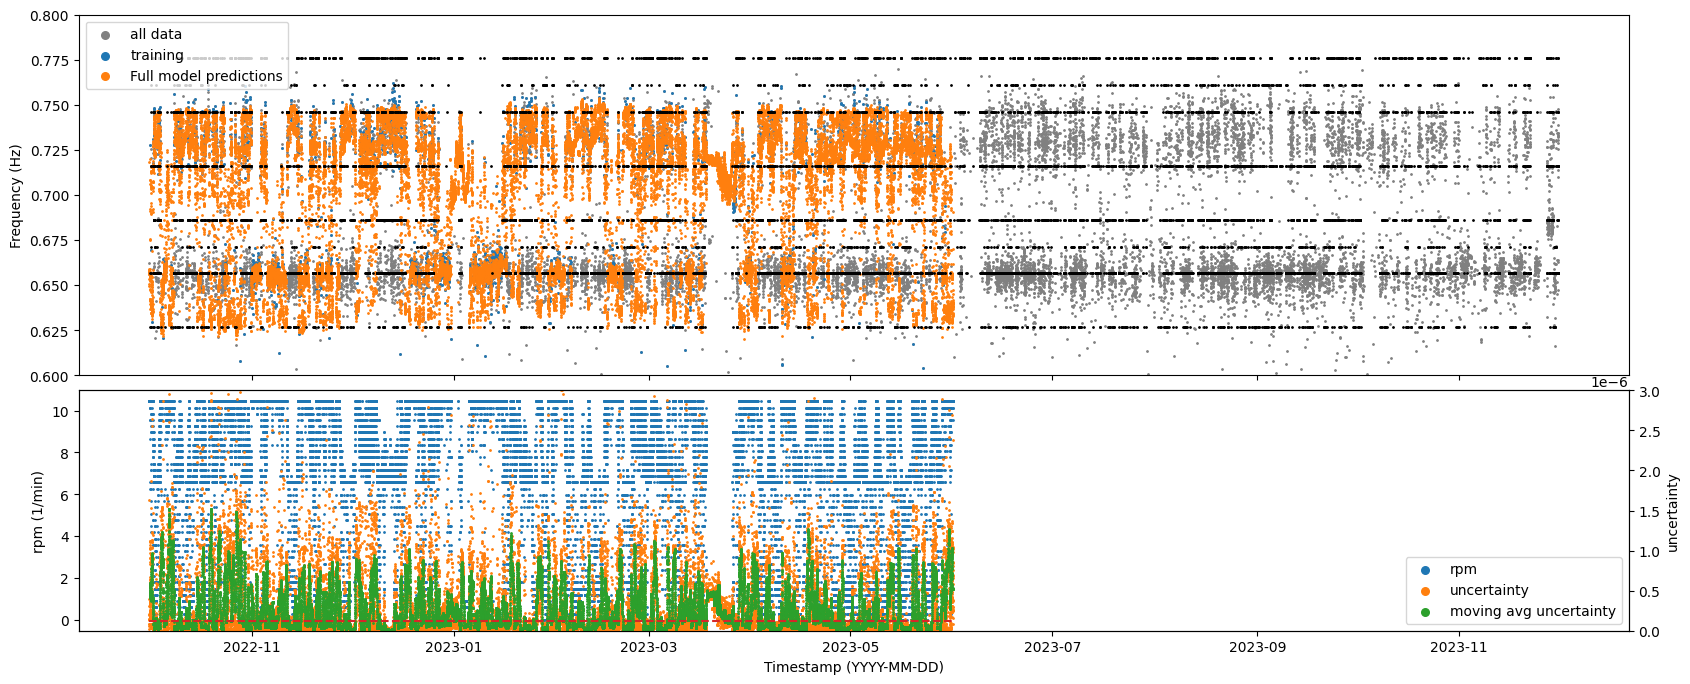

In [ ]:
# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(all_whirling.index, all_whirling['mean_frequency'], s=1, color='gray', label='all data')
ax1.scatter(y_train.index, y_train, s=1, color='tab:blue', label='training')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=1, color='tab:orange', label='Full model predictions')
#ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=5, color='tab:orange', label='Smart tracking')
legend1 = ax1.legend(loc='upper left')

for harmonic in harmonics_data:
    ax1.scatter(harmonics_data.index, harmonics_data[harmonic], s=1, color='k')

for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')
ax1.set_ylim(0.6, 0.8)
# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed

plt.show()
plt.close()

In [ ]:
uncertainty_lim

1.2478224965266391e-07

In [ ]:
# Smart tracking
from src.smart_tracking.smart_tracking import *

smart_tracked_modes = smart_tracking(
    all_whirling['mean_frequency'],
    predictions_df['prediction'],
    uncertainty_,
    uncertainty_lim,
    prediction_lim
    )

smart_tracked_modes.to_parquet(os.path.join(data_folder, 'processed', loc, mode, turbine+'_' + mode + '_smart_tracked_modes.parquet'))

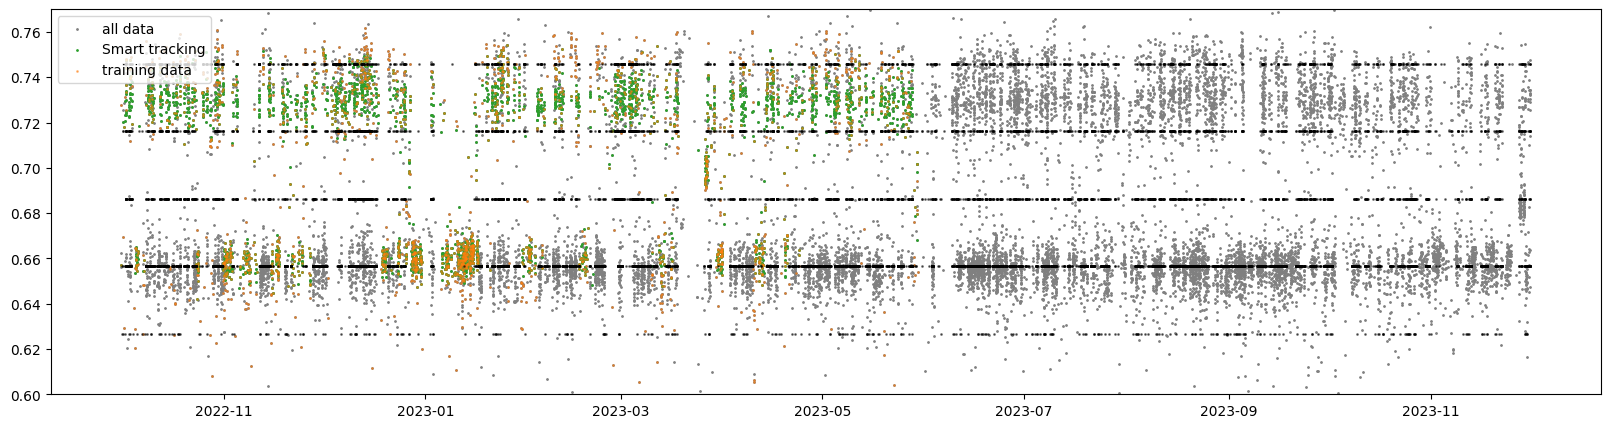

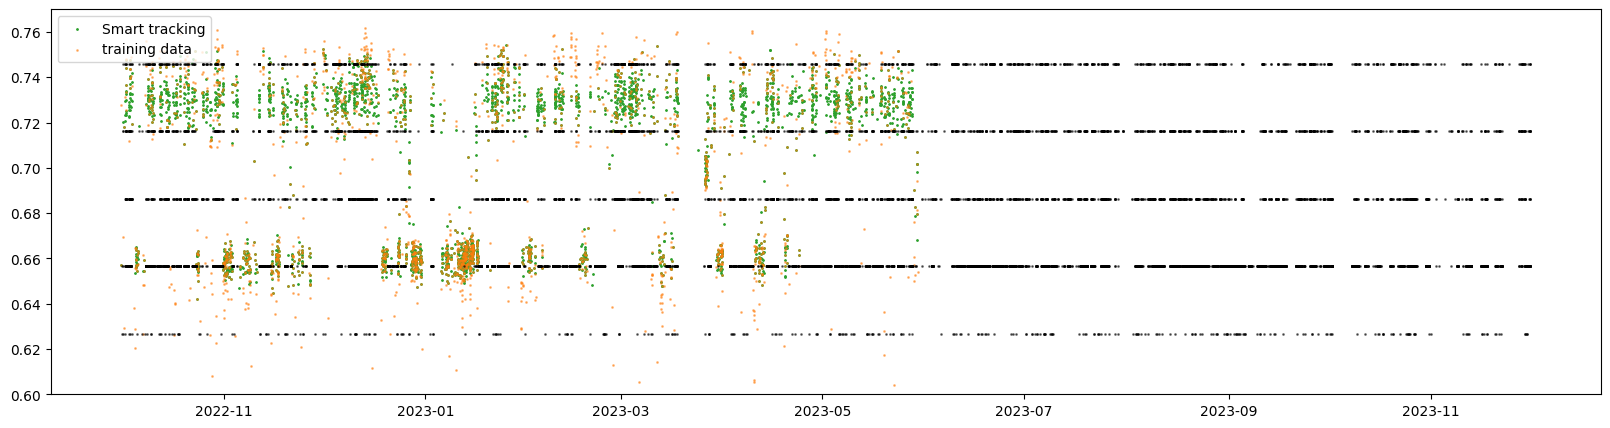

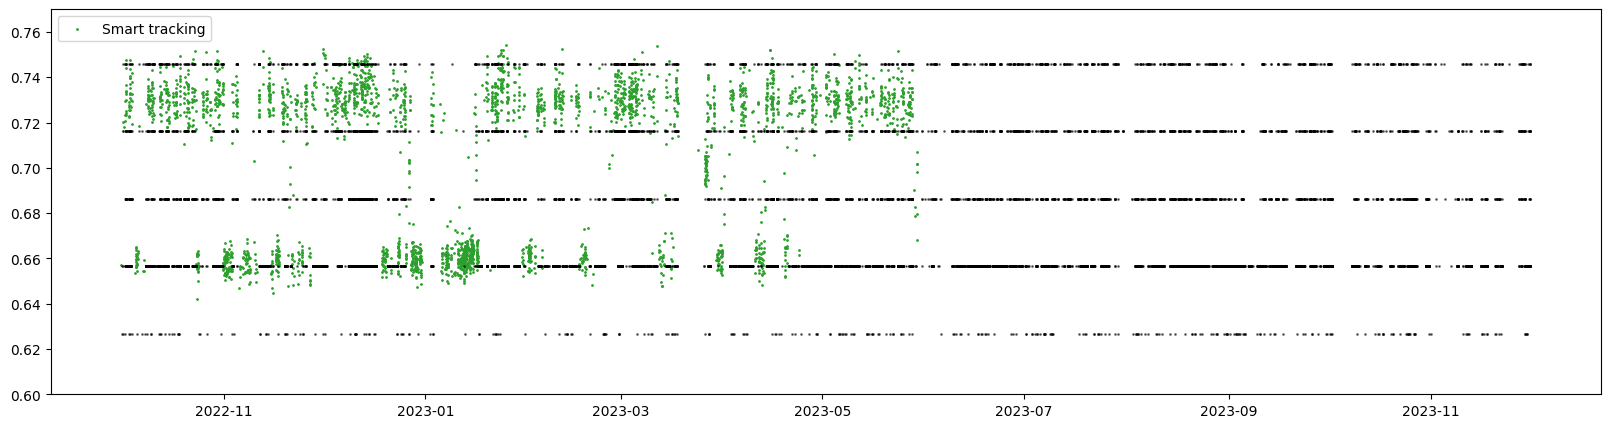

In [ ]:
plt.figure(figsize=(20,5))
plt.scatter(all_whirling.index, all_whirling['mean_frequency'], s=1, color='gray', label='all data')
#plt.scatter(predictions_df.index, predictions_df['prediction'],color='tab:blue', s=1, alpha=0.5)
plt.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:green', label='Smart tracking')
plt.scatter(y_train.index, y_train, s=1, alpha=0.5, color='tab:orange', label='training data')
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data[harmonic].index, harmonics_data[harmonic], color='k', alpha=0.5, s=1)
#plt.scatter(predictions_df.index, predictions_df['prediction'], s=1, alpha=0.5)
plt.legend(loc='upper left')
plt.ylim(0.6, 0.77)
plt.show()
plt.close()

plt.figure(figsize=(20,5))
plt.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:green', label='Smart tracking')
plt.scatter(y_train.index, y_train, s=1, alpha=0.5, color='tab:orange', label='training data')
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data[harmonic].index, harmonics_data[harmonic], color='k', alpha=0.5, s=1)
#plt.scatter(predictions_df.index, predictions_df['prediction'], s=1, alpha=0.5)
plt.legend(loc='upper left')
plt.ylim(0.6, 0.77)
plt.show()
plt.close()

plt.figure(figsize=(20,5))
plt.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:green', label='Smart tracking')
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data[harmonic].index, harmonics_data[harmonic], color='k', alpha=0.5, s=1)
#plt.scatter(predictions_df.index, predictions_df['prediction'], s=1, alpha=0.5)
plt.legend(loc='upper left')
plt.ylim(0.6, 0.77)
plt.show()
plt.close()

In [ ]:
smart_tracked_modes

frequency  difference
timestamp                                       
2022-10-01 00:50:00+00:00   0.657105    0.000578
2022-10-01 12:00:00+00:00   0.720262    0.004957
2022-10-02 00:30:00+00:00   0.717832    0.004907
2022-10-02 02:50:00+00:00   0.723341    0.007668
2022-10-02 07:50:00+00:00   0.720634    0.006968
...                              ...         ...
2023-05-29 12:30:00+00:00   0.701491    0.003482
2023-05-29 13:10:00+00:00   0.698200    0.003063
2023-05-29 13:20:00+00:00   0.701539    0.005873
2023-05-29 13:50:00+00:00   0.679407    0.006657
2023-05-29 16:20:00+00:00   0.668044    0.005603

[3011 rows x 2 columns]

In [ ]:
harmonics_data

harmonic_1p  harmonic_3p  harmonic_6p  harmonic_9p
timestamp                                                                    
2022-10-01 00:00:00+00:00          NaN          NaN          NaN          NaN
2022-10-01 00:10:00+00:00     0.174083      0.52225       1.0445      1.56675
2022-10-01 00:20:00+00:00     0.174083      0.52225       1.0445      1.56675
2022-10-01 00:30:00+00:00     0.174083      0.52225       1.0445      1.56675
2022-10-01 00:40:00+00:00     0.174083      0.52225       1.0445      1.56675
...                                ...          ...          ...          ...
2023-11-30 23:20:00+00:00     0.119367      0.35810       0.7162      1.07430
2023-11-30 23:30:00+00:00     0.114400      0.34320       0.6864      1.02960
2023-11-30 23:40:00+00:00     0.119367      0.35810       0.7162      1.07430
2023-11-30 23:50:00+00:00     0.109417      0.32825       0.6565      0.98475
2023-12-01 00:00:00+00:00     0.114400      0.34320       0.6864      1.02960

[61292 rows x 4 columns]

(4.0, 12.0)

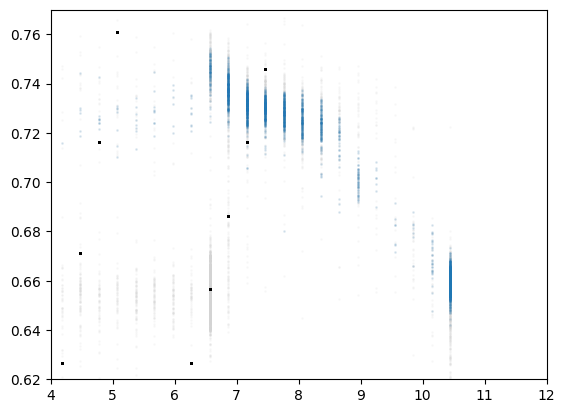

In [ ]:
smart_tracked_modes['rpm'] = X.loc[smart_tracked_modes.index, 'mean_NW2_C02_rpm']
h_X_common_indices = harmonics_data.index.intersection(X.index)
harmonics_data['rpm'] = X.loc[h_X_common_indices, 'mean_NW2_C02_rpm']
common_indices = all_whirling.index.intersection(X.index)
all_whirling_ = all_whirling.loc[common_indices]
all_whirling_['rpm'] = X.loc[common_indices, 'mean_NW2_C02_rpm']
plt.scatter(all_whirling_['rpm'], all_whirling_['mean_frequency'], s=1, alpha=0.1, color='lightgrey')
plt.scatter(smart_tracked_modes['rpm'], smart_tracked_modes['frequency'], s=1, alpha=0.1)
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data['rpm'], harmonics_data[harmonic], color='k', alpha=0.5, s=1)
plt.ylim(0.62, 0.77)
plt.xlim(4,12)

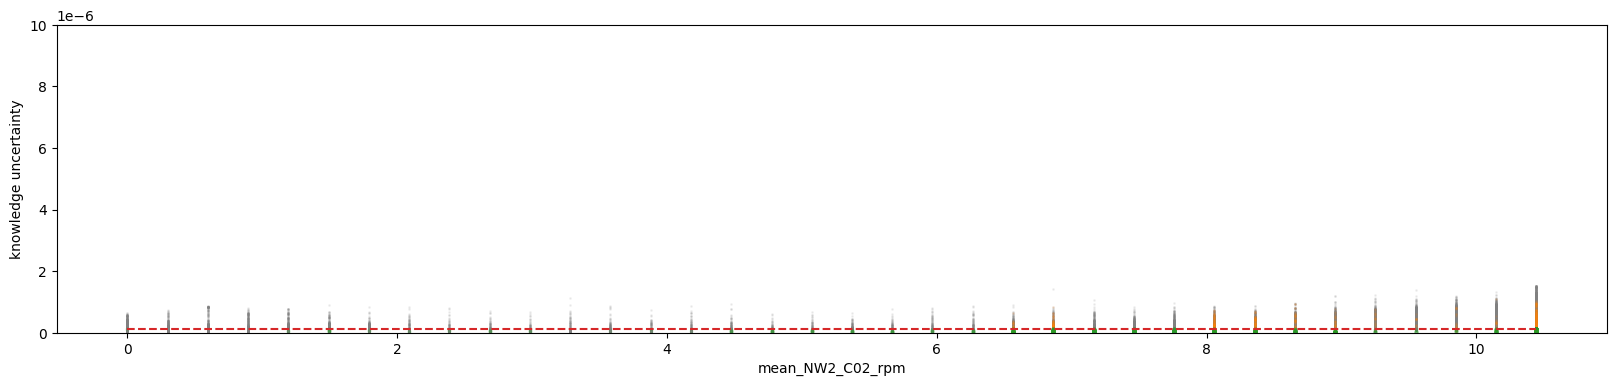

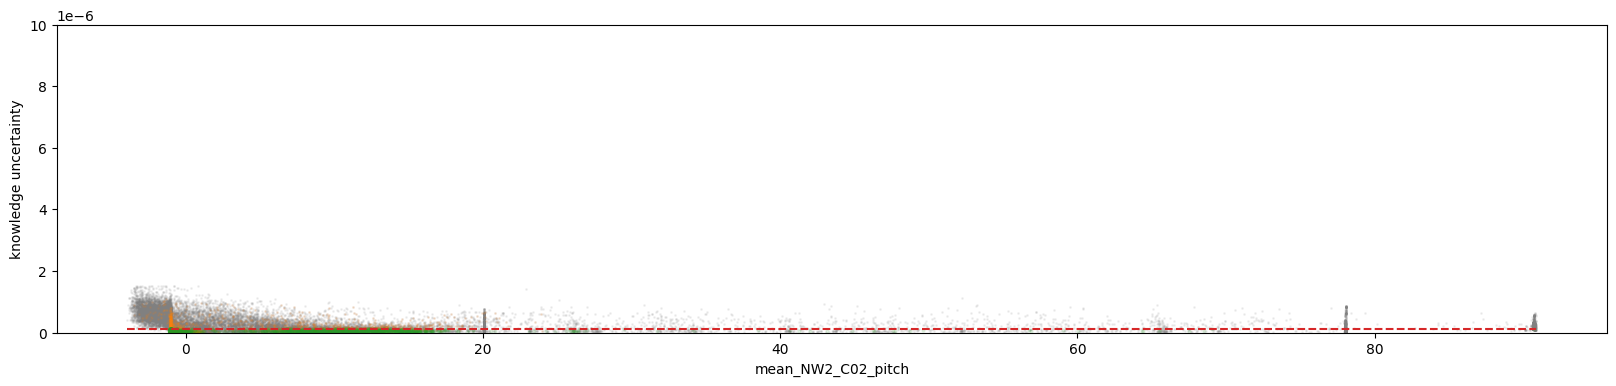

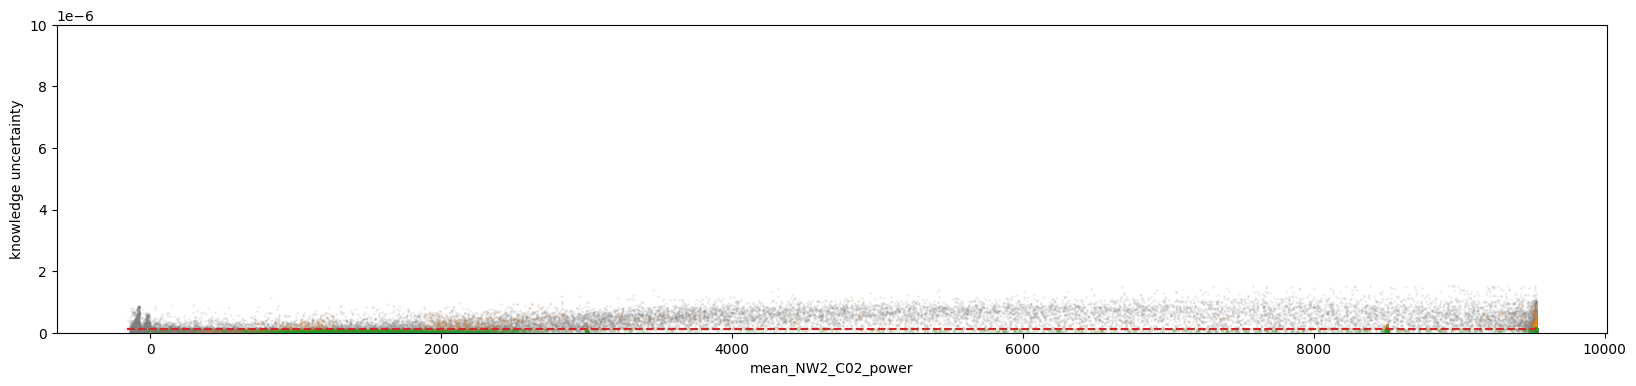

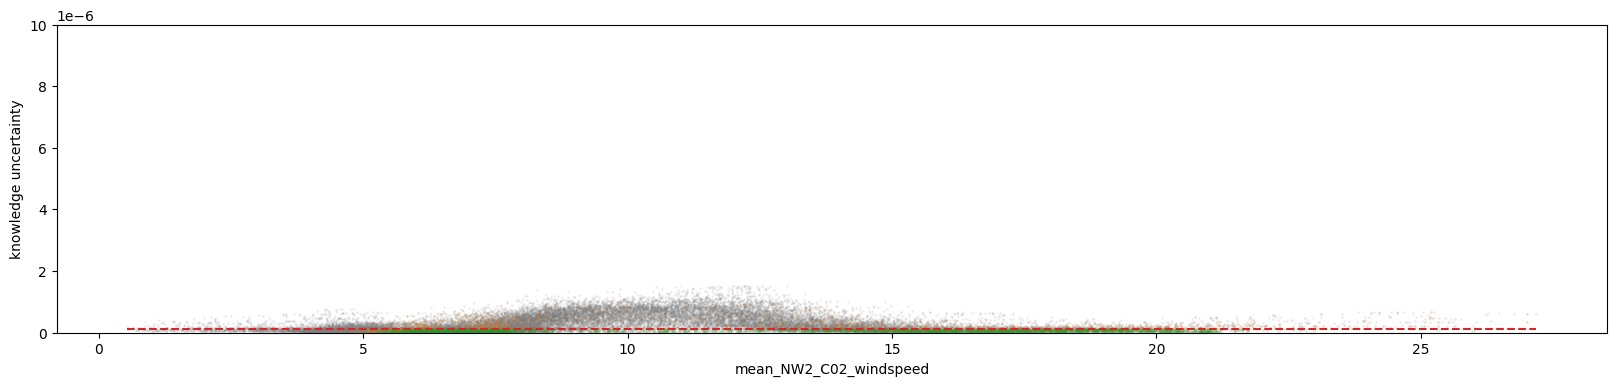

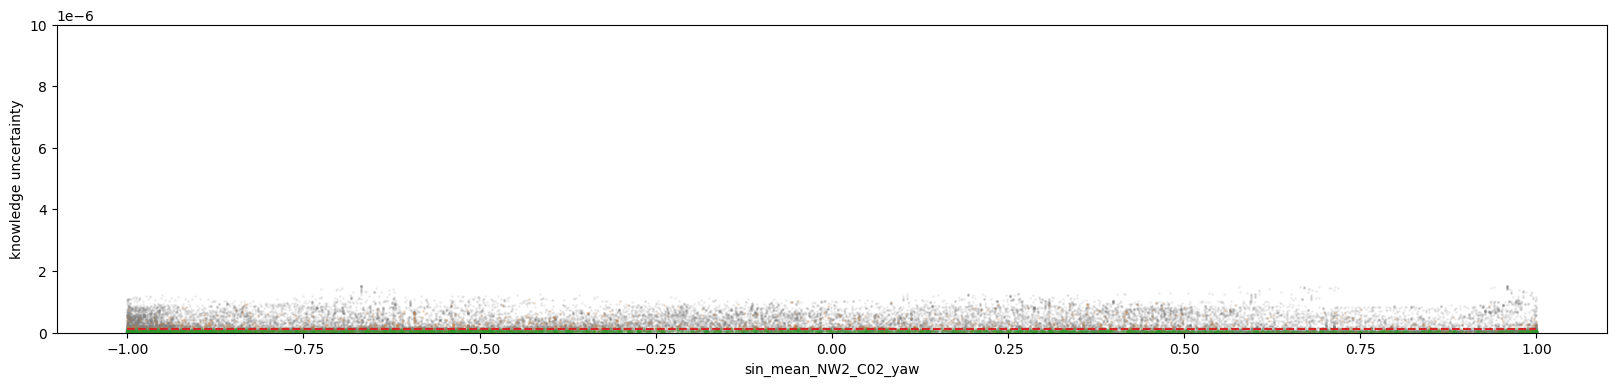

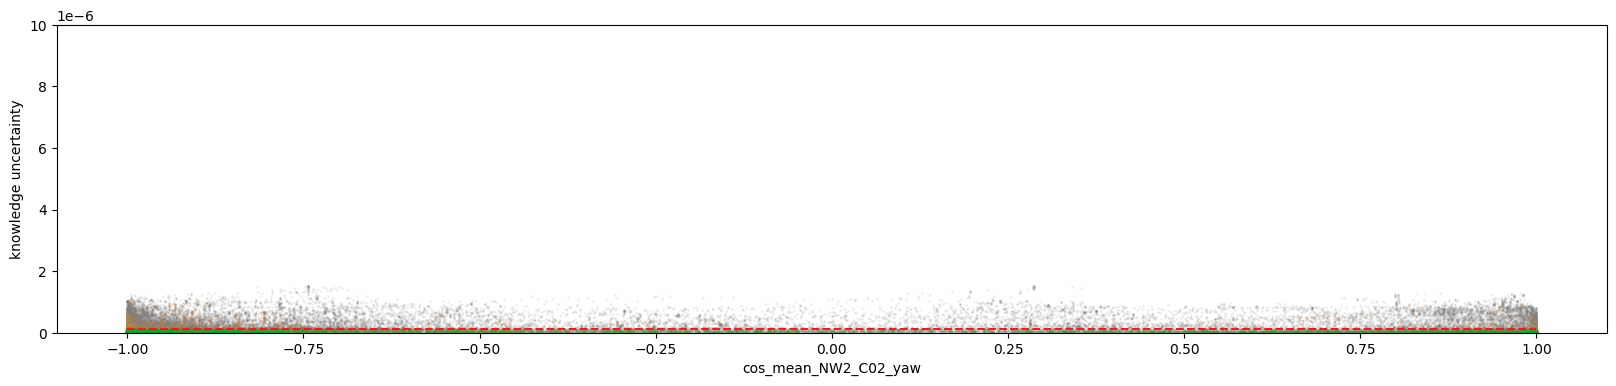

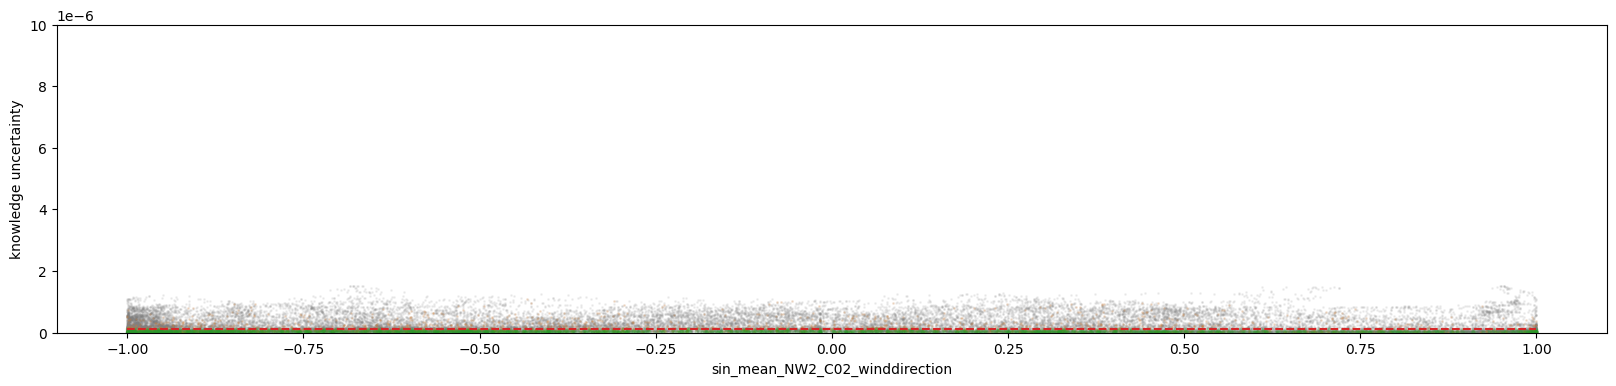

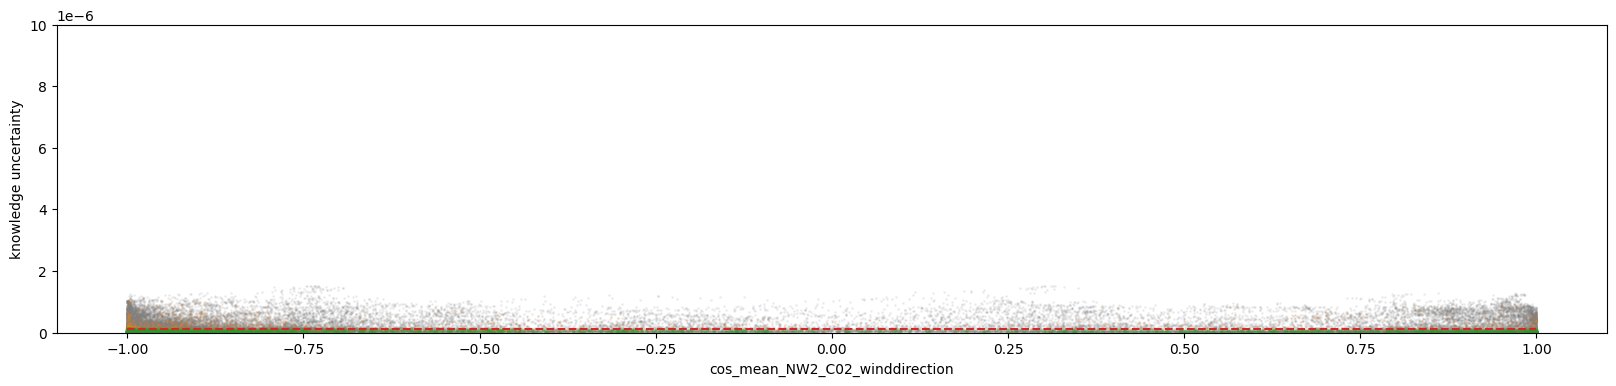

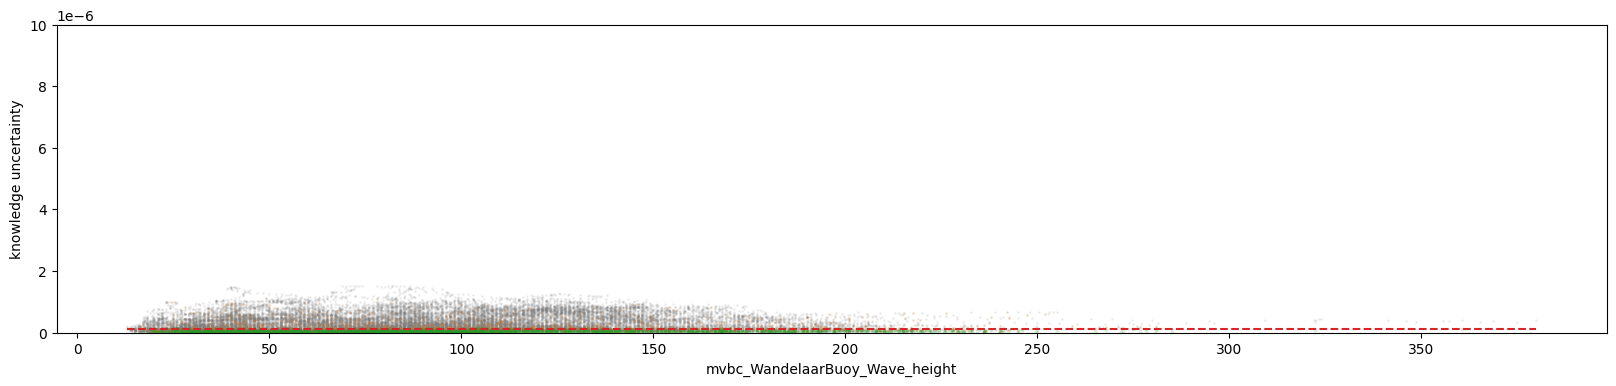

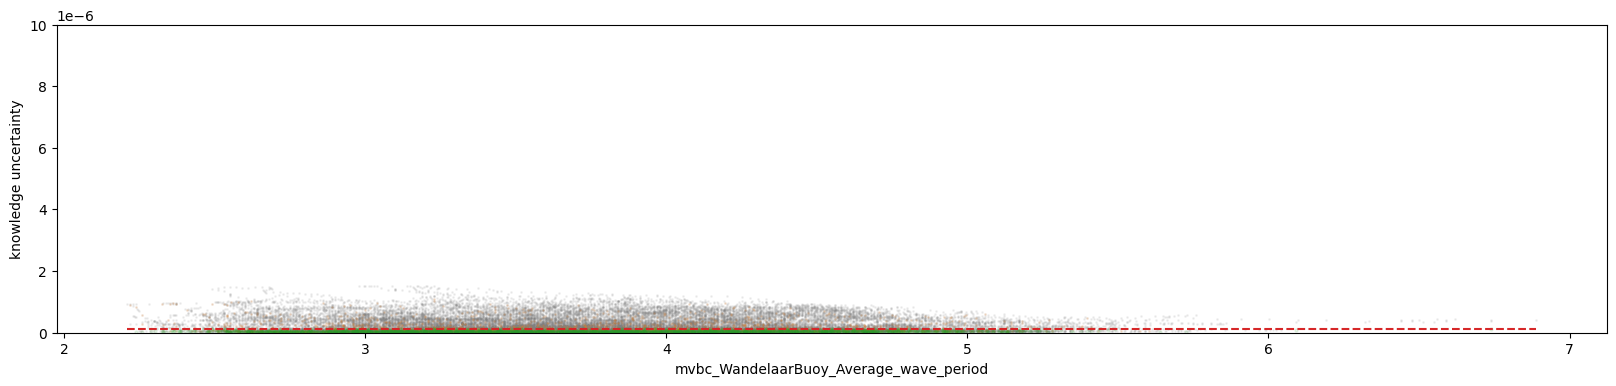

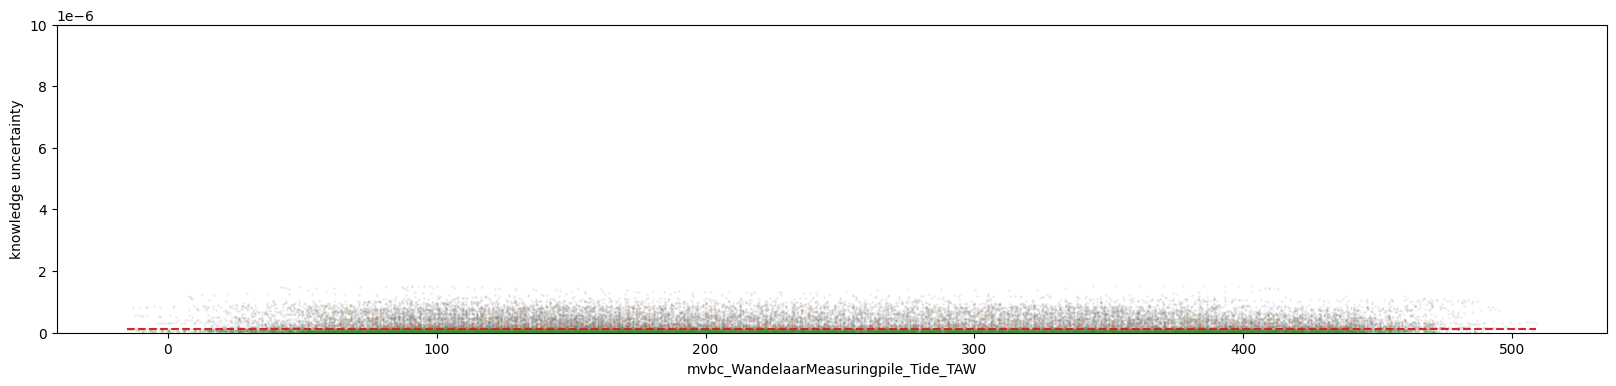

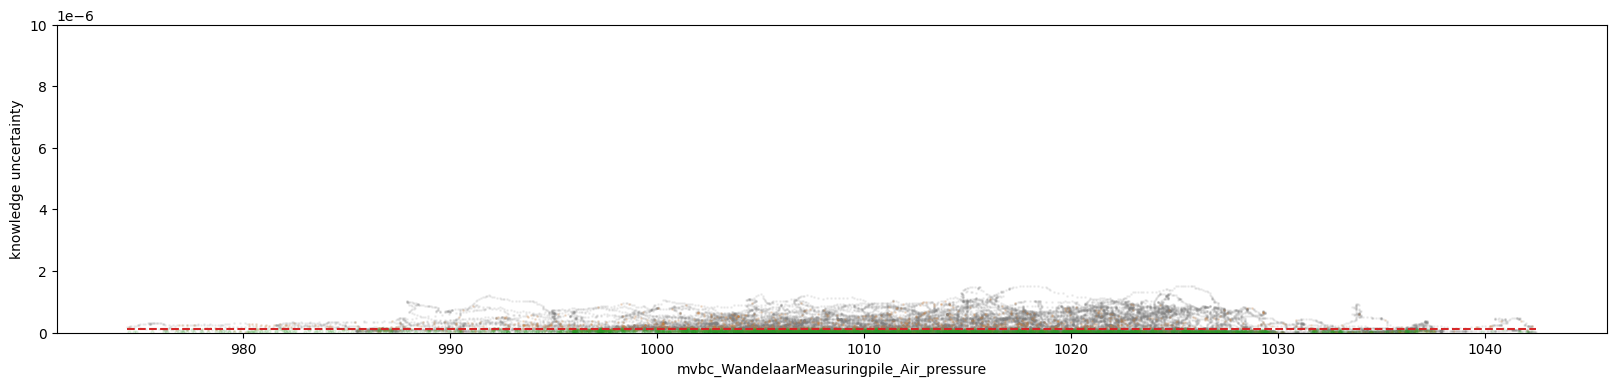

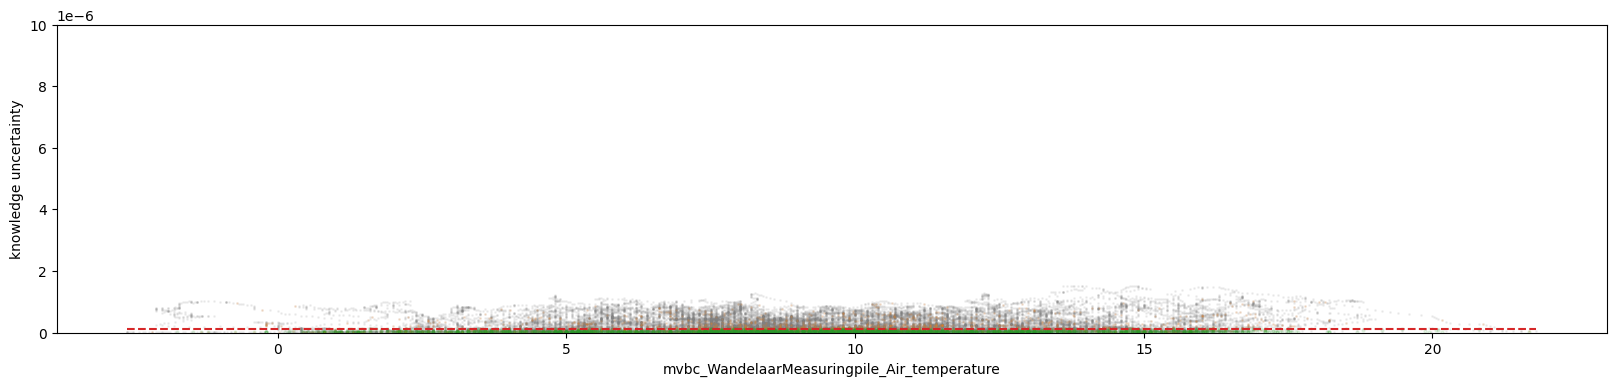

In [ ]:
for col in X.columns:
    plt.figure(figsize=(20,4))
    plt.scatter(X[col], uncertainty_moving_avg, s=1, alpha=0.1, color='grey')
    plt.scatter(X[col].loc[X_train.index], uncertainty_moving_avg.loc[X_train.index], s=1, alpha=0.1, color='tab:orange')
    plt.scatter(X[col].loc[smart_tracked_modes.index], uncertainty_.loc[smart_tracked_modes.index], s=5, alpha=0.1, color='tab:green')

    plt.xlabel(col)
    plt.ylabel('knowledge uncertainty')
    plt.ylim(-1e-9, 10*1e-6)
    plt.hlines(uncertainty_lim, X[col].min(), X[col].max(), color='tab:red', linestyles='dashed')
    plt.show()
    plt.close()

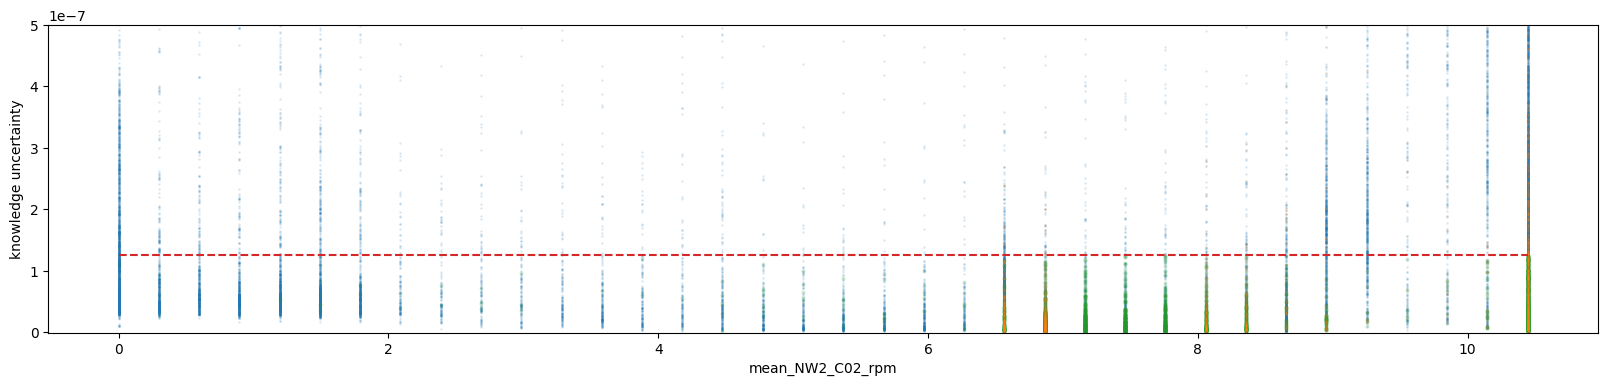

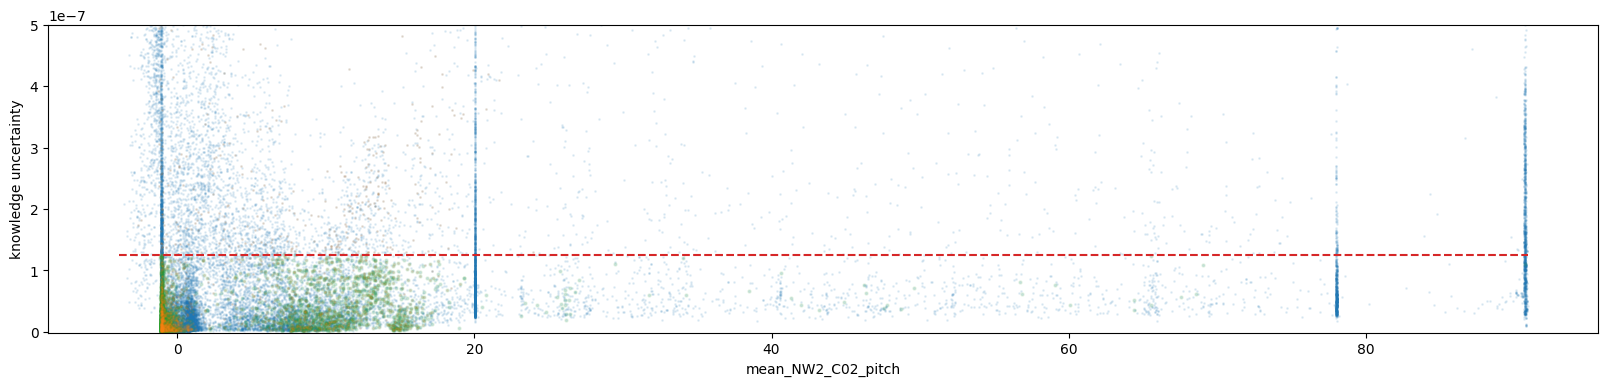

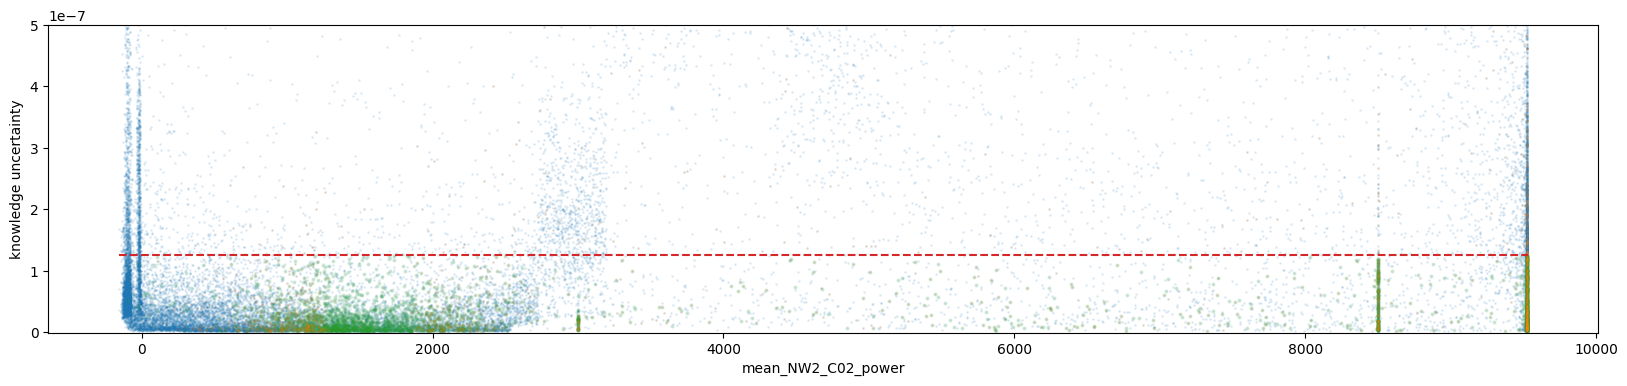

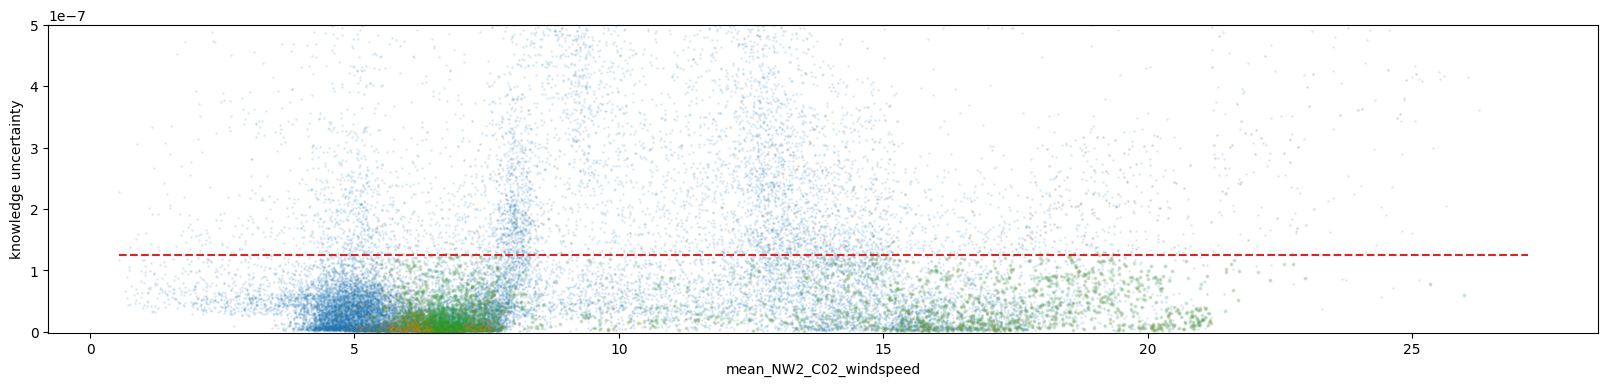

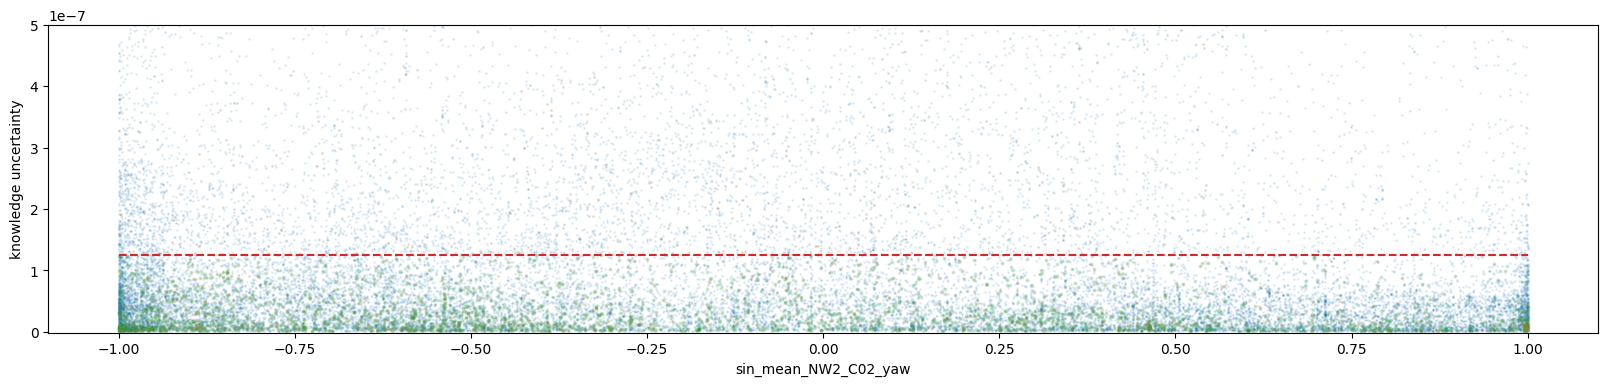

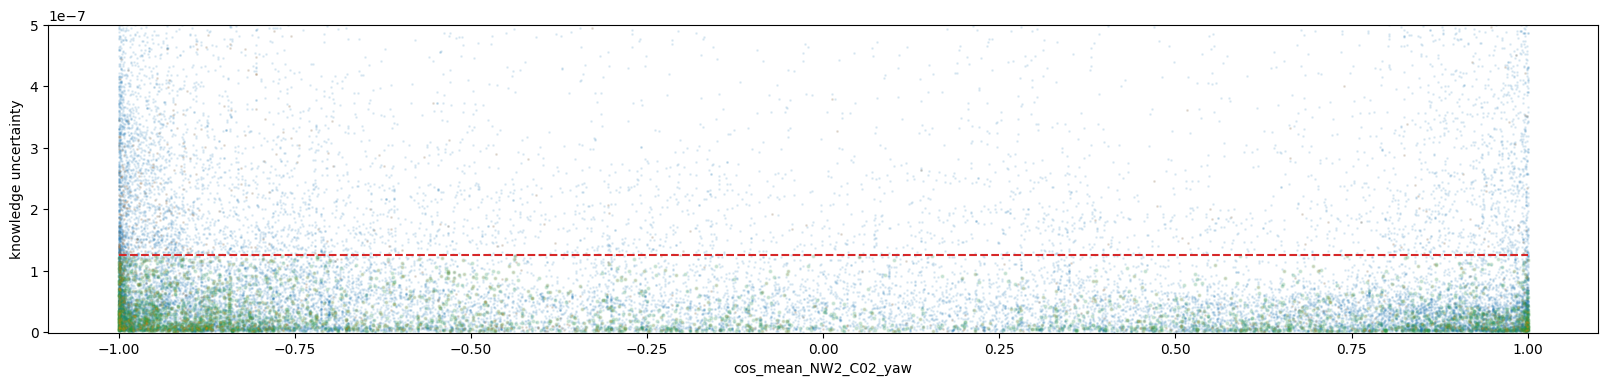

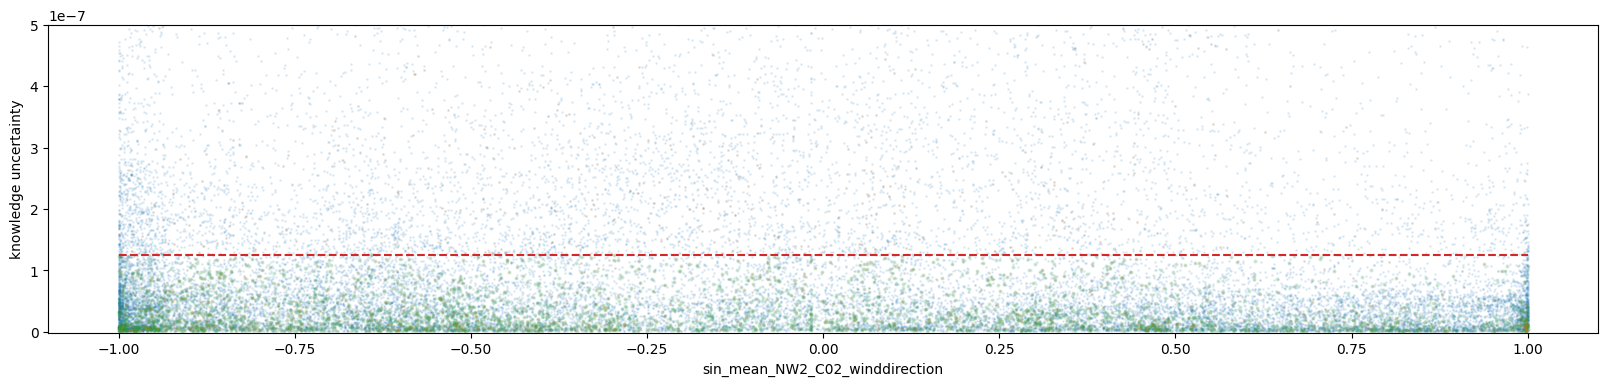

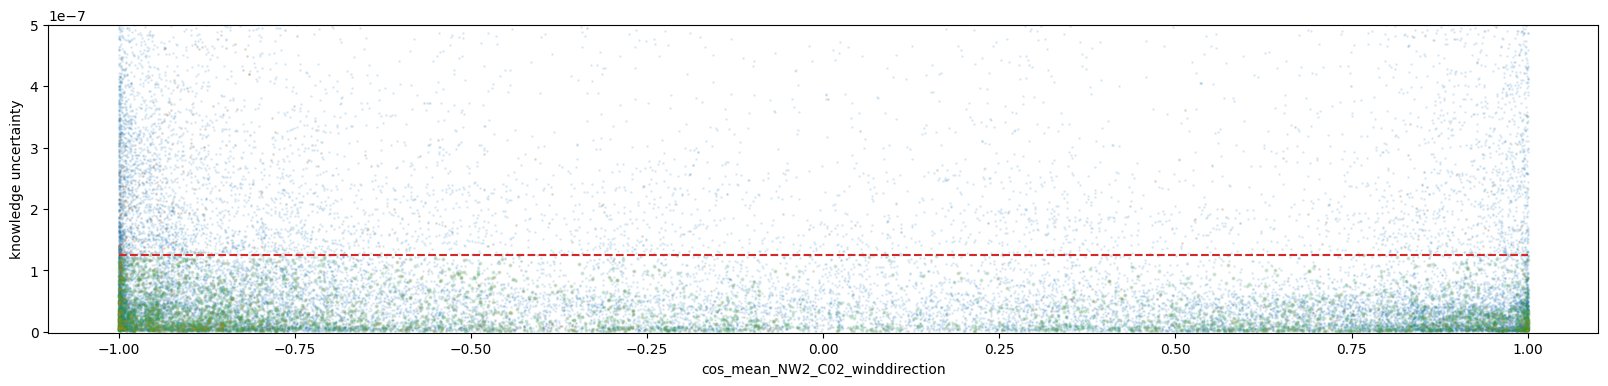

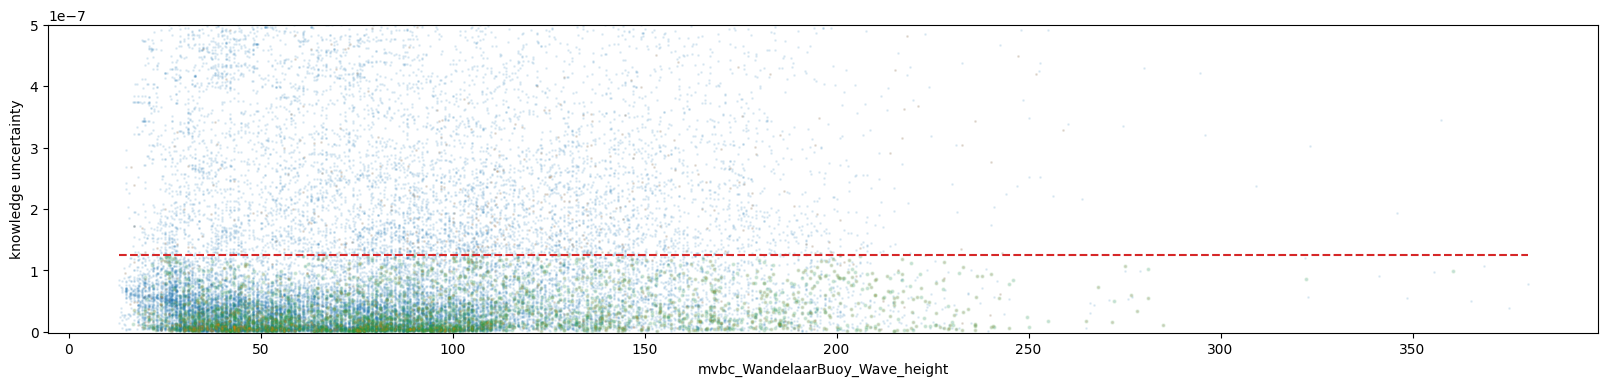

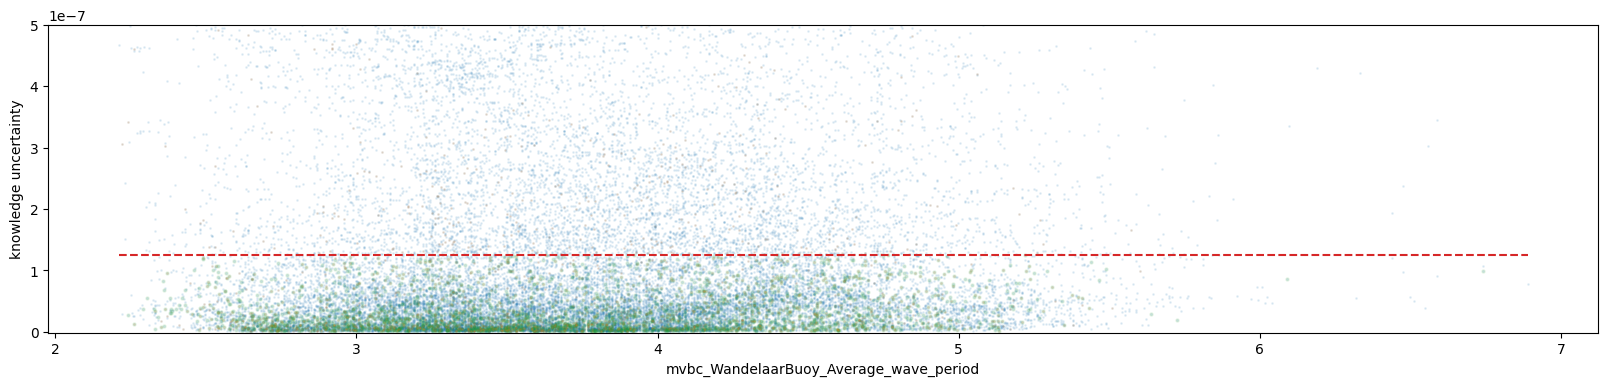

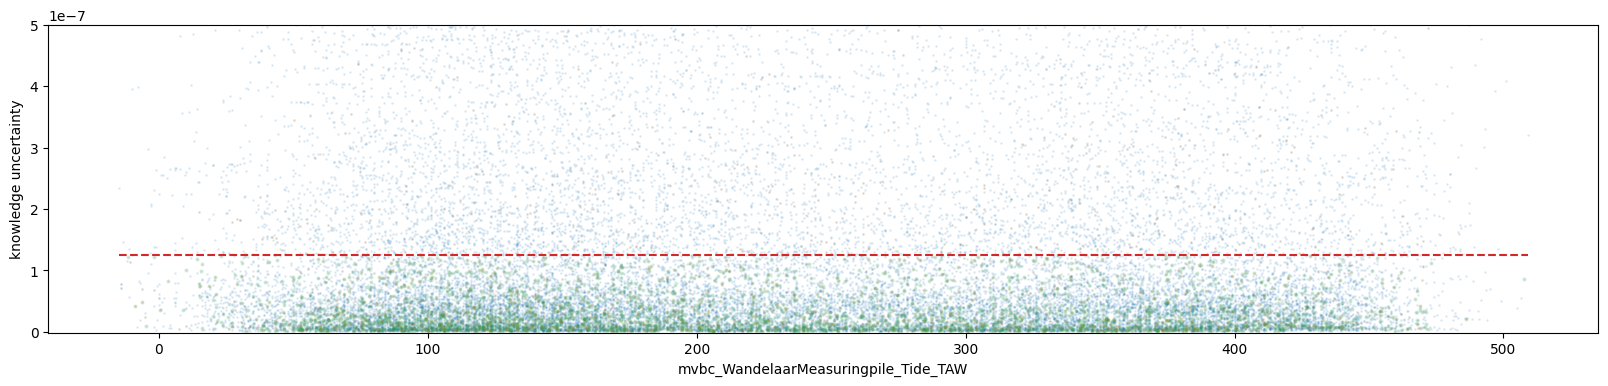

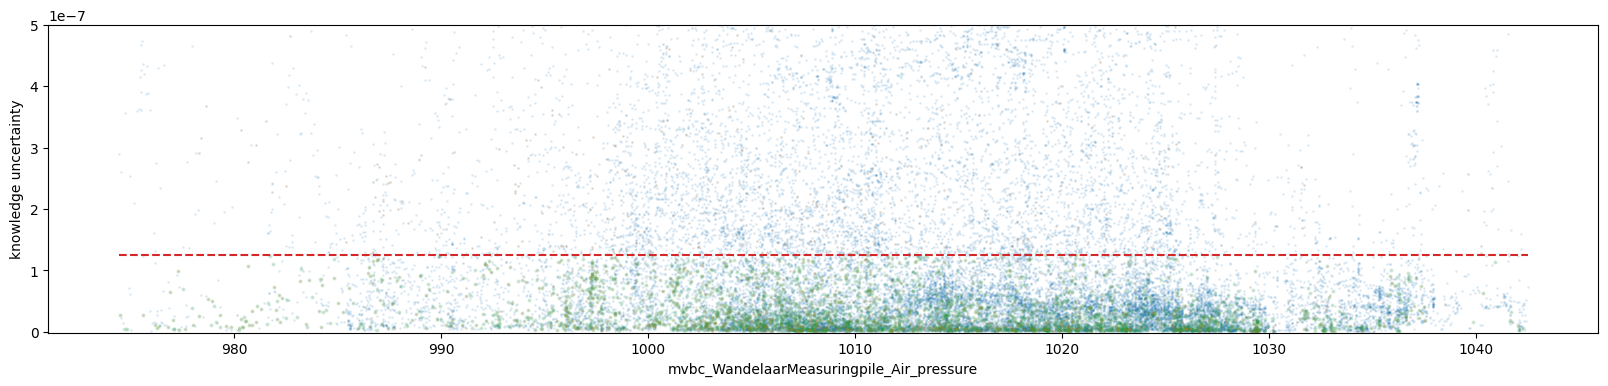

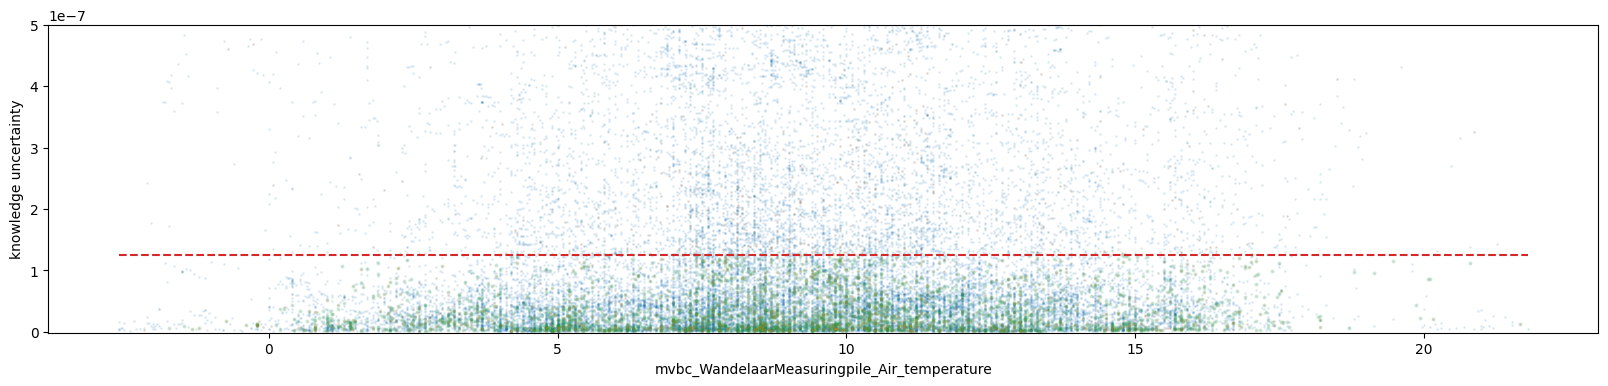

In [ ]:

for col in X.columns:
    plt.figure(figsize=(20,4))
    plt.scatter(X[col], predictions_df['knowledge_uncertainty'], s=1, alpha=0.1)
    plt.scatter(X[col].loc[smart_tracked_modes.index], predictions_df['knowledge_uncertainty'].loc[smart_tracked_modes.index], s=5, alpha=0.1, color='tab:green')
    plt.scatter(X[col].loc[X_train.index], predictions_df['knowledge_uncertainty'].loc[X_train.index], s=1, alpha=0.1)
    plt.xlabel(col)
    plt.ylabel('knowledge uncertainty')
    plt.ylim(-1e-9, 0.5*1e-6)
    plt.hlines(uncertainty_lim, X[col].min(), X[col].max(), color='tab:red', linestyles='dashed')
    plt.show()
    plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_19604\2269479091.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handles in legend.legendHandles:


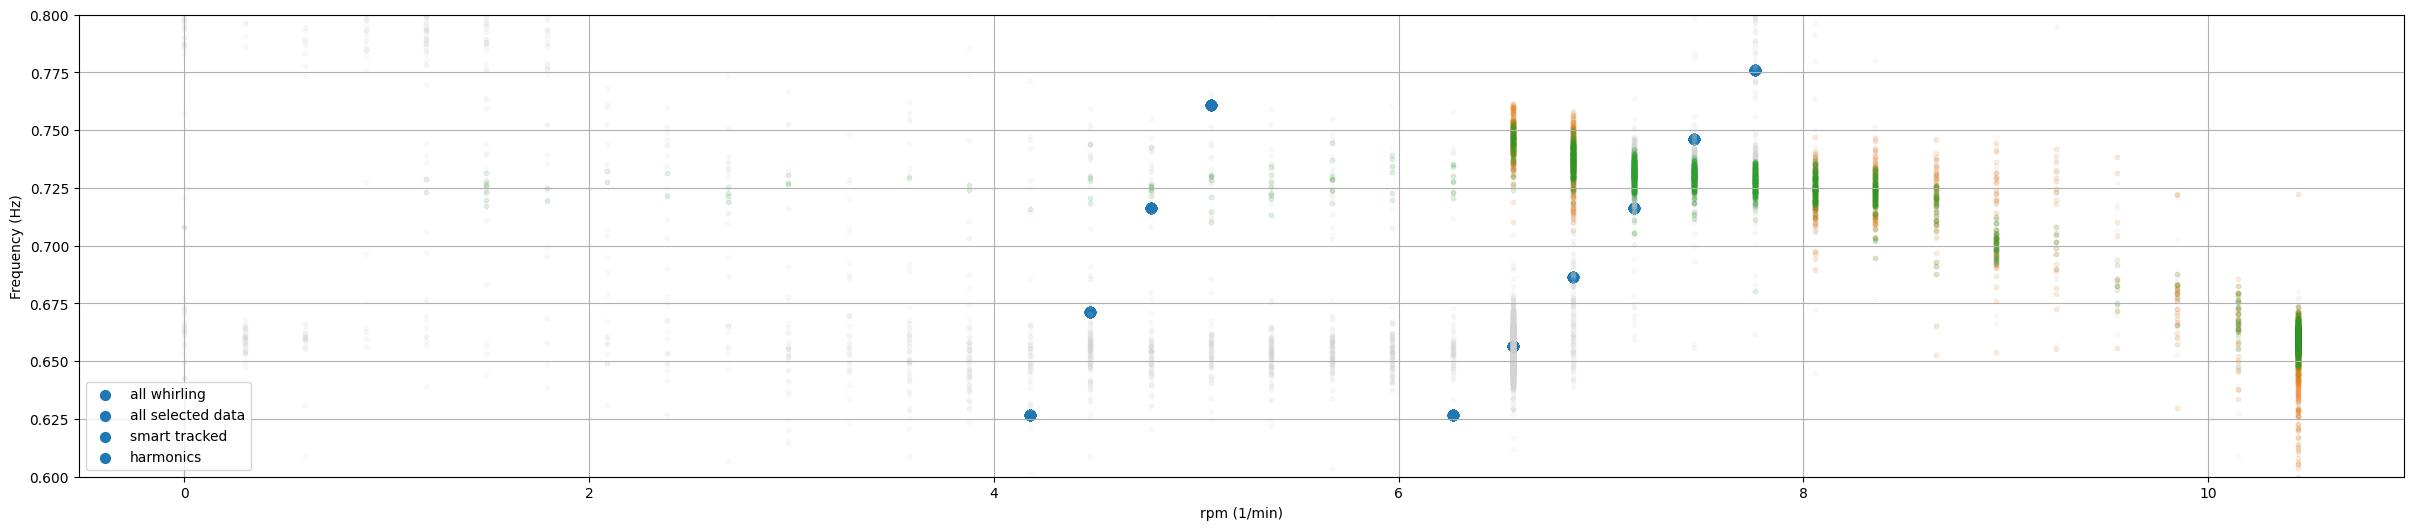

In [ ]:
campbell_data = pd.DataFrame({'frequency': mpe_ss_data['mean_frequency']}, index=mpe_ss_data.index)
campbell_data['rpm'] = X.filter(regex='rpm').loc[campbell_data.index.intersection(X.index)]
harmonics_data['rpm'] = X.filter(regex='rpm').loc[harmonics_data.index.intersection(X.index)]
smart_tracked_modes['rpm'] = X.filter(regex='rpm').loc[smart_tracked_modes.index]

campbell_data_train = pd.DataFrame({'frequency': y_train}, index=y_train.index)
campbell_data_train['rpm'] = X_train.filter(regex='rpm')
plt.figure(figsize=(30,6))
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data['rpm'], harmonics_data[harmonic], s=50, alpha=1.0, color='tab:blue')
plt.scatter(campbell_data['rpm'], campbell_data['frequency'], s=10, alpha=0.1, color='lightgrey')
#plt.scatter(mpe_ss_data_lowrpm.index, mpe_ss_data_lowrpm['mean_frequency'], s=10, alpha=0.6, color='tab:green')
plt.scatter(campbell_data_train['rpm'], campbell_data_train['frequency'], s=10, alpha=0.1, color='tab:orange')
plt.scatter(smart_tracked_modes['rpm'], smart_tracked_modes['frequency'], s=10, alpha=0.1, color='tab:green')


plt.ylim(0, 1.15)
legend = plt.legend(loc='lower left', labels=['all whirling', 'all selected data', 'smart tracked', 'harmonics'])
for handles in legend.legendHandles:
    handles.set_sizes([50])
    handles.set_alpha(1.0)
plt.xlabel('rpm (1/min)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0.6, 0.8)
plt.grid()
plt.show()
plt.close()

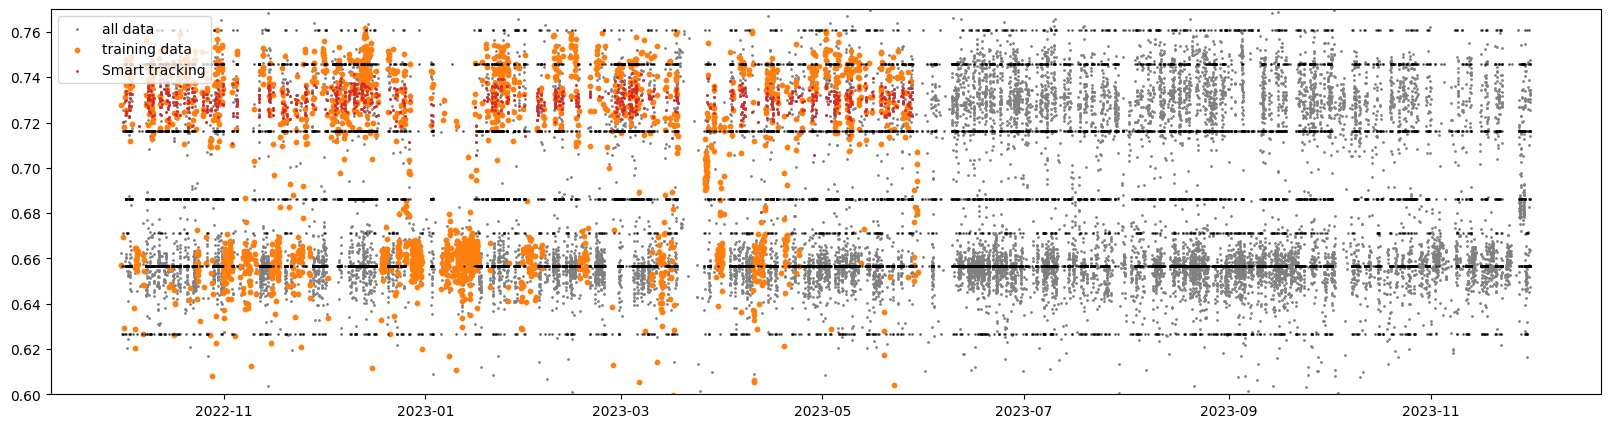

In [ ]:
smart_tracked_modes_harmonic = smart_tracked_modes.copy()
X_harm = X[(X[X.filter(regex='rpm').columns[0]]>7) &(X[X.filter(regex='rpm').columns[0]]<8)]
smart_tracked_modes_harmonic = smart_tracked_modes_harmonic.loc[X_harm.index.intersection(smart_tracked_modes_harmonic.index)]

plt.figure(figsize=(20,5))
plt.scatter(all_whirling.index, all_whirling['mean_frequency'], s=1, color='gray', label='all data')
#plt.scatter(predictions_df.index, predictions_df['prediction'],color='tab:blue', s=1, alpha=0.5)
#plt.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:green', label='Smart tracking')
plt.scatter(y_train.index, y_train, s=10, alpha=1.0, color='tab:orange', label='training data')
#plt.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:blue', label='Smart tracking')
plt.scatter(smart_tracked_modes_harmonic.index, smart_tracked_modes_harmonic['frequency'], s=1, color='tab:red', label='Smart tracking')
for harmonic in harmonics_data.columns[:-1]:
    plt.scatter(harmonics_data[harmonic].index, harmonics_data[harmonic], color='k', alpha=0.5, s=1)
#plt.scatter(predictions_df.index, predictions_df['prediction'], s=1, alpha=0.5)
plt.legend(loc='upper left')
plt.ylim(0.6, 0.77)
plt.show()
plt.close()